In [6]:
using CMBLensing, PythonPlot


[ Info: Precompiling CMBLensing [b60c06c0-7e54-11e8-3788-4bd722d65317] (cache misses: include_dependency fsize change (2), wrong dep version loaded (2), wrong source (2))

SYSTEM: caught exception of type :MethodError while trying to print a failed Task notice; giving up
┌ Error: LLVM extensions library unavailable for your platform:
│   aarch64-apple-darwin-libgfortran5-cxx11-llvm_version+18-julia_version+1.12.1
│ LLVM.jl will not be functional.
│ 
│ If you are using a custom version of LLVM, try building a
│ custom version of LLVMExtra_jll using `deps/build_local.jl`
└ @ LLVM ~/.julia/packages/LLVM/bzSzE/src/LLVM.jl:103
  NOTE: Assumed "Diagonal" refers to `LinearAlgebra.Diagonal`. This behavior is deprecated and may differ in future versions.`
  NOTE: This behavior may have differed in Julia versions prior to 1.12.
  Hint: If you intended to create a new generic function of the same name, use `function Diagonal end`.
  Hint: To silence the warning, qualify `Diagonal` as `LinearAlgeb

MAPEestimation

In [7]:
Cℓ = camb(r=0.05, ℓmax=16000);

In [8]:
Cℓn = noiseCℓs(μKarcminT=6, ℓknee=100);

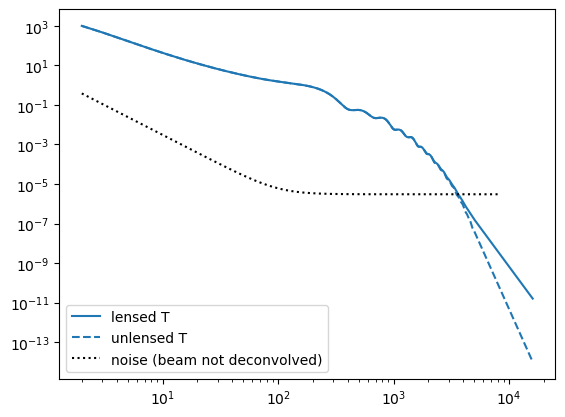

In [9]:
loglog(Cℓ.total.TT,c="C0")
loglog(Cℓ.unlensed_total.TT,"--",c="C0")
loglog(Cℓn.TT,"k:")

legend(["lensed T","unlensed T", "noise (beam not deconvolved)"]);

In [10]:
θpix  = 2        # pixel size in arcmin
Nside = 128      # number of pixels per side in the map
pol   = :I       # type of data to use (can be :T, :P, or :TP)
T     = Float32  # data type (Float32 is ~2 as fast as Float64);
bandpass_mask = LowPass(7000);

In [11]:

(;f, f̃, ϕ, ds) = load_sim(
    seed = 3,
    Cℓ = Cℓ,
    Cℓn = Cℓn,
    θpix = θpix,
    T = T,
    Nside = Nside,
    #beamFWHM = 1.4,
    pol = pol,
    bandpass_mask = bandpass_mask, 
    #pixel_mask_kwargs = (edge_padding_deg=0, apodization_deg=0, num_ptsrcs=0),
)

(;Cf, Cϕ) = ds;

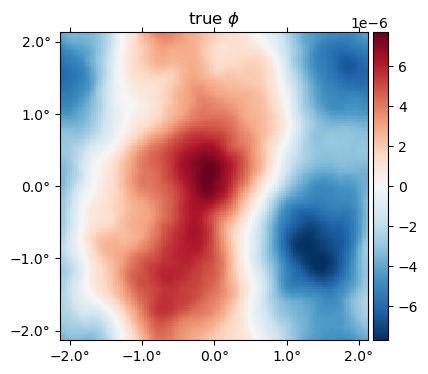

In [12]:
PythonPlot.plot(ϕ, title = raw"true $\phi$");


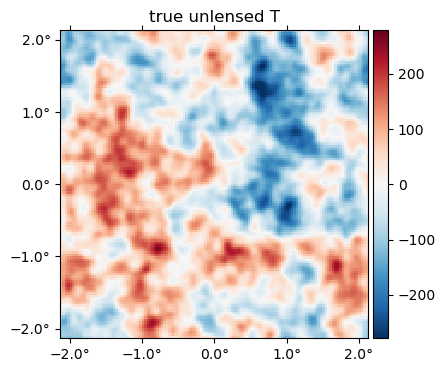

In [13]:
PythonPlot.plot(f, title = "true unlensed " .* ["T"]);

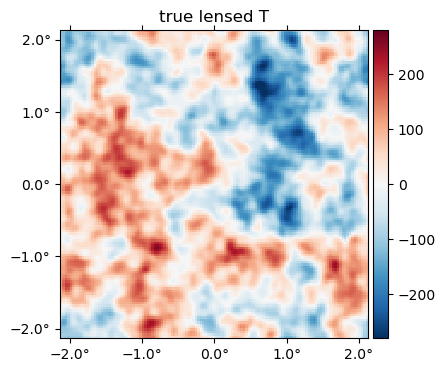

In [14]:
PythonPlot.plot(LenseFlow(ϕ)*f, title = "true lensed " .* ["T"]);

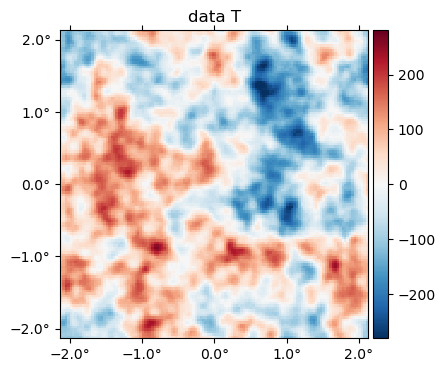

In [15]:
PythonPlot.plot(ds.d, title = "data " .* ["T"]);

In [16]:
fJ, ϕJ, hist = MAP_joint(ds, nsteps=50, progress=true);



MAP_joint: 100%|████████████████████████████████████████| Time: 0:16:37
         step: 50
       logpdf: 276711.06
            α: 0.00030942974
     ΔΩ°_norm: 6e-06
           CG: 2 iterations (2.82 sec)
   Linesearch: 2 bisections (5.86 sec)


<sys>:0: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


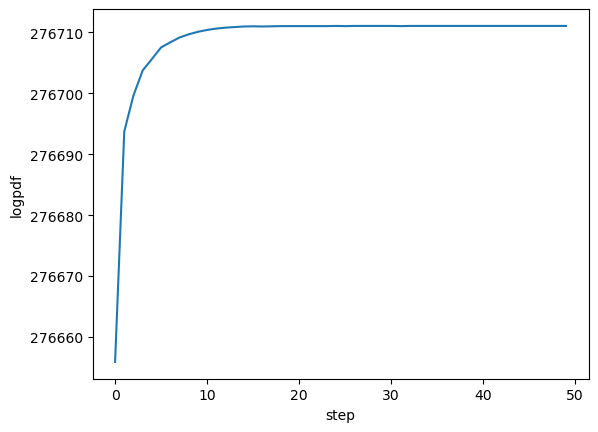

In [17]:
PythonPlot.plot(getindex.(hist, :logpdf))
xlabel("step")
ylabel("logpdf");
PythonPlot.show()

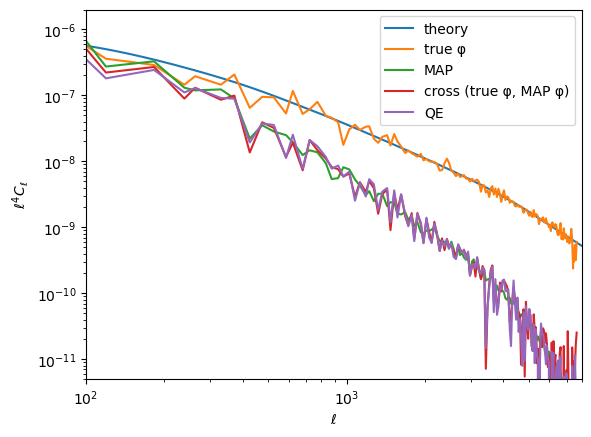

In [18]:
# --- φ power spectra: theory vs MAP vs QE ---


loglog(ℓ⁴ * Cℓ.total.ϕϕ,   label="theory")
loglog(get_ℓ⁴Cℓ(ϕ),         label="true φ")
loglog(get_ℓ⁴Cℓ(ϕJ),       label="MAP")
loglog(get_ℓ⁴Cℓ(ϕ, ϕJ),    label="cross (true φ, MAP φ)") 
loglog(get_ℓ⁴Cℓ(ϕ, quadratic_estimate(ds).ϕqe), label="QE") # QE reconstruction quality
xlim(100, 8000); ylim(5e-12, 2e-6); legend()
xlabel(raw"$\ell$")
ylabel(raw"$\ell^4 C_\ell$");
PythonPlot.show()


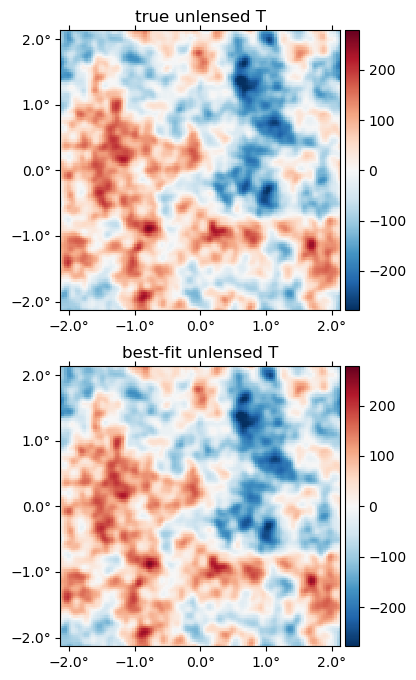

In [19]:
plot([f,fJ], title = ["true", "best-fit"] .* " unlensed " .* ["T"]);

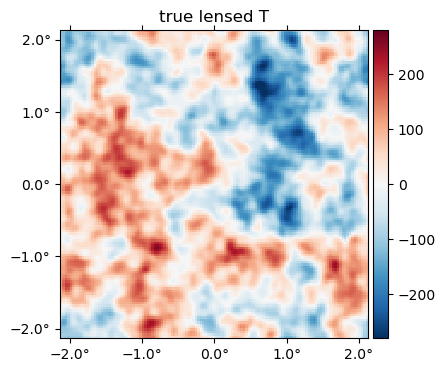

In [20]:
plot([f̃], title = ["true"] .* " lensed " .* ["T"]);

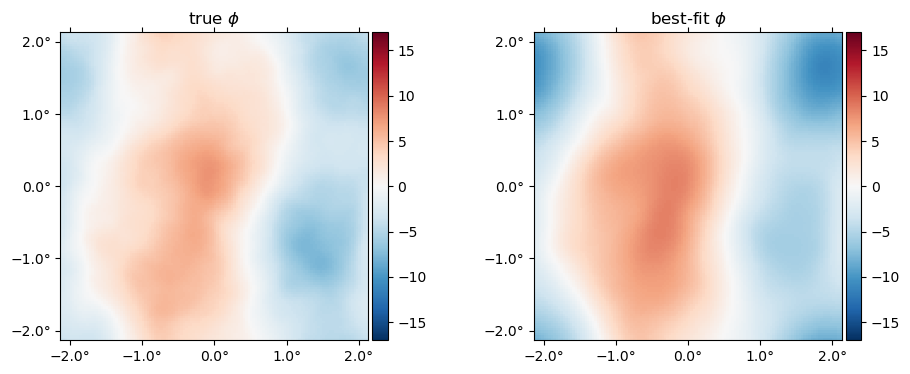

In [21]:
PythonPlot.plot(10^6*[ϕ ϕJ], title=["true" "best-fit"] .* raw" $\phi$", vlim=17)


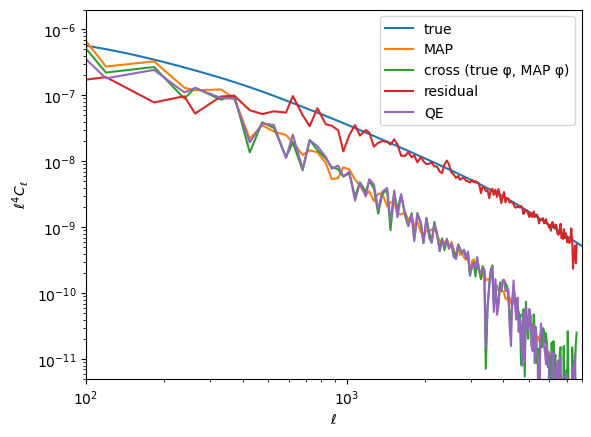

In [41]:

loglog(ℓ⁴ * Cℓ.total.ϕϕ,   label="true")
loglog(get_ℓ⁴Cℓ(ϕJ),       label="MAP")
loglog(get_ℓ⁴Cℓ(ϕ, ϕJ),    label="cross (true φ, MAP φ)") 
loglog(get_ℓ⁴Cℓ(ϕJ-ϕ),     label="residual")
loglog(get_ℓ⁴Cℓ(ϕ, quadratic_estimate(ds).ϕqe), label="QE") # QE reconstruction quality
xlim(100, 8000); ylim(5e-12, 2e-6); legend()
xlabel(raw"$\ell$")
ylabel(raw"$\ell^4 C_\ell$");
PythonPlot.show()

In [53]:
semilogx(get_ρℓ(ϕ,ϕJ))
semilogx(get_ρℓ(quadratic_estimate(ds).ϕqe,ϕJ))
legend(["Joint MAP", "QE"])

LoadError: UndefVarError: `get_Cℓ_cross` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [ ]:
using FFTW, StatsBase
using CMBLensing: Cℓs, m_rfft, ifftshift, LambertS0, Map

"""
    get_Cℓ_fft(f1::LambertS0, f2::LambertS0=f1)

Compute auto / cross C_ell(f1,f2) explicitly using FFT.
Returns Cℓs(ℓ, Cℓ).
"""
function get_Cℓ_fft(f1::LambertS0, f2::LambertS0=f1; nbins=300)

    # --- Convert Lambert field → flat map (real-space matrix) ---
    a = Map(f1).arr       # Ny×Nx real matrix
    b = Map(f2).arr

    Ny, Nx = size(a)
    @assert size(b) == (Ny, Nx)

    # pixel size (steradian width, NOT arcmin)
    θpix_rad = deg2rad(f1.metadata.θpix / 60)

    # --- 1) FFT (only keep half-plane via rfft) ---
    F1 = m_rfft(a, (1,2))       # Ny × (Nx/2+1) complex
    F2 = m_rfft(b, (1,2))

    NyF, NxF = size(F1)

    # --- 2) Cross power ---
    Pk = real.(F1 .* conj.(F2))     # cross spectrum (NyF×NxF)

    area_sr = Nx * Ny * θpix_rad^2  # area of flat sky patch
    Pk ./= area_sr                  # normalize → power / steradian

    # --- 3) ℓ grid from projection metadata ---
    proj = f1.metadata              # this is ProjLambert
    ℓx = proj.ℓx                    # Nx values (FFT order!)
    ℓy = proj.ℓy                    # NyF values (only stored half)

    # Make full 2D ℓ map matching rfft layout
    ℓx2D = repeat(ℓx', NyF, 1)
    ℓy2D = repeat(ℓy , 1,  NxF)
    ℓmap = @. sqrt(ℓx2D^2 + ℓy2D^2)   # NyF×NxF

    # --- 4) Radial binning ---
    ℓmin, ℓmax = minimum(ℓmap), maximum(ℓmap)
    edges = range(ℓmin, ℓmax; length=nbins+1)

    Cℓ  = zeros(Float64, nbins)
    ℓc  = zeros(Float64, nbins)

    for i in 1:nbins
        mask = (edges[i] .<= ℓmap .< edges[i+1])   # NyF×NxF BitMatrix
        if any(mask)
            Cℓ[i] = mean(Pk[mask])
            ℓc[i] = mean(ℓmap[mask])
        else
            Cℓ[i] = NaN
            ℓc[i] = (edges[i] + edges[i+1]) / 2
        end
    end

    return Cℓs(ℓc, Cℓ)
end


get_Cℓ_fft